<a href="https://colab.research.google.com/github/zpenct/Analisis-Data/blob/main/Network_Sicepat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kolom yang tersedia: Index(['conversation_id_str', 'created_at', 'favorite_count', 'label',
       'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang',
       'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url',
       'user_id_str', 'username'],
      dtype='object')

📌 Top 5 pengguna paling berpengaruh (degree centrality):
sicepat_ekspres: 0.2372
tanyarlfes: 0.1387
tokopedia: 0.0511
ShopeeID: 0.0438
TokopediaCare: 0.0255

📌 Jumlah komunitas ditemukan: 114


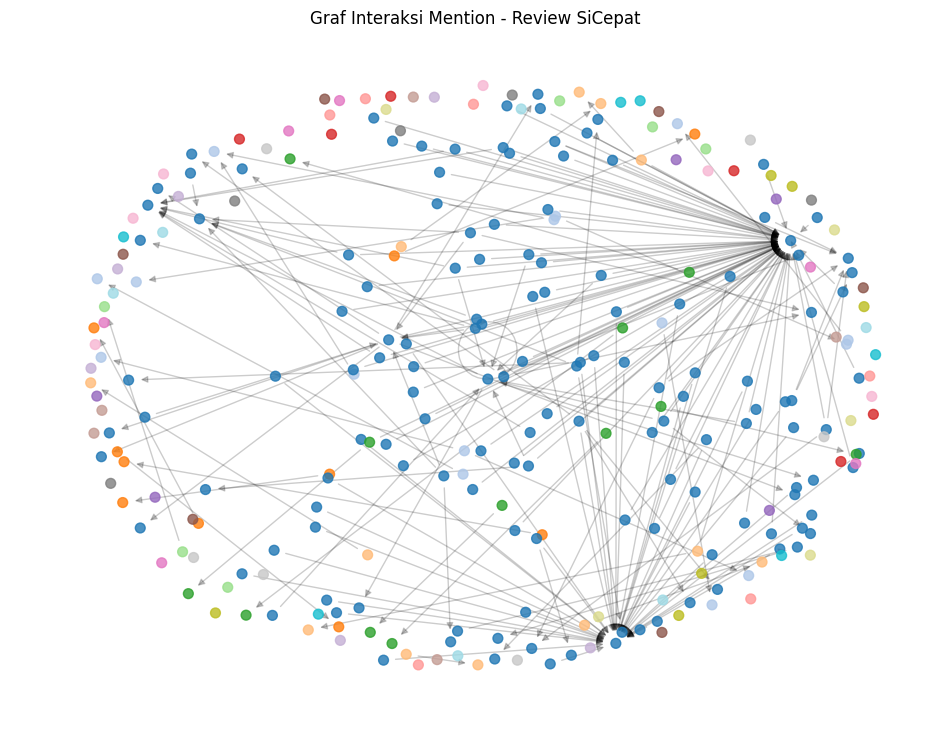

In [ ]:
# =======================
# 1. PERSIAPAN DATA
# =======================
import pandas as pd
import re

# Load data
df = pd.read_csv("scrapping-review-sicepat.csv")

# Lihat kolom yang tersedia
print("Kolom yang tersedia:", df.columns)

# Ganti ini sesuai nama kolom teks tweet di datamu
text_column = "full_text"       # kolom teks isi tweet
user_column = "username"        # kolom nama pengguna
retweet_column = "retweet_count" if "retweet_count" in df.columns else None
like_column = "like_count" if "like_count" in df.columns else None

# Ekstrak mention dari tweet
def extract_mentions(text):
    return re.findall(r"@(\w+)", str(text))

df["mentions"] = df[text_column].apply(extract_mentions)

# =======================
# 2. BANGUN GRAF JEJARING
# =======================
import networkx as nx

G = nx.DiGraph()

# Tambahkan edge berdasarkan mention
for _, row in df.iterrows():
    source_user = row[user_column]
    mentioned_users = row["mentions"]
    for target_user in mentioned_users:
        if target_user != "":
            G.add_edge(source_user, target_user, interaction="mention")

# Tambahkan atribut node: total retweet dan like
for _, row in df.iterrows():
    user = row[user_column]
    if not G.has_node(user):
        G.add_node(user)
    if retweet_column:
        G.nodes[user]["retweet"] = G.nodes[user].get("retweet", 0) + int(row[retweet_column])
    if like_column:
        G.nodes[user]["like"] = G.nodes[user].get("like", 0) + int(row[like_column])

# =======================
# 3. CENTRALITY ANALYSIS
# =======================
centrality = nx.degree_centrality(G)
sorted_users = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

print("\n📌 Top 5 pengguna paling berpengaruh (degree centrality):")
for user, score in sorted_users[:5]:
    print(f"{user}: {score:.4f}")

# =======================
# 4. KOMUNITAS & MODULARITAS
# =======================
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
print(f"\n📌 Jumlah komunitas ditemukan: {len(communities)}")

# Label komunitas
community_map = {}
for i, community in enumerate(communities):
    for user in community:
        community_map[user] = i

nx.set_node_attributes(G, community_map, "community")

# =======================
# 5. VISUALISASI GRAF
# =======================
import matplotlib.pyplot as plt

# Ambil posisi layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Warna berdasarkan komunitas
node_colors = [community_map.get(node, 0) for node in G.nodes()]

plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.tab20, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Graf Interaksi Mention - Review SiCepat")
plt.axis("off")
plt.show()


In [ ]:
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = text.strip()
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus link
    text = re.sub(r'[^\w\s,.!?]', '', text, flags=re.UNICODE)  # Hapus emoji/simbol
    text = re.sub(r'\s+', ' ', text)  # Hapus spasi berlebih

    return text

# Load dataset hasil scraping
df = pd.read_csv("scrapping-review-sicepat.csv")

df= df.drop_duplicates(subset="full_text")

# Terapkan pembersihan
df['cleaned_text'] = df['full_text'].apply(clean_text)

# --- EXTRACT EDGES (mention, reply, retweet) ---
edges = []
for _, row in df.iterrows():
    source = row['username']

    # Mention
    mentions = re.findall(r'@(\w+)', row['full_text'])
    for target in mentions:
        edges.append((source, target, 'mention'))

    # Reply
    if pd.notna(row['in_reply_to_screen_name']):
        edges.append((source, row['in_reply_to_screen_name'], 'reply'))

    # Retweet
    if row['full_text'].startswith("RT @"):
        match = re.match(r"RT @(\w+)", row['full_text'])
        if match:
            edges.append((source, match.group(1), 'retweet'))

# --- EDGE LIST UNTUK GEPHI ---
edge_rows = []
for source, target, interaction in edges:
    edge_rows.append({
        'Source': source,
        'Target': target,
        'Type': 'Directed',
        'Weight': 1,
        'Interaction': interaction
    })

df_edges = pd.DataFrame(edge_rows)
df_edges = df_edges.groupby(['Source', 'Target', 'Type', 'Interaction']).agg({'Weight': 'sum'}).reset_index()

# --- NODE LIST UNTUK GEPHI ---
all_users = set(df_edges['Source']).union(set(df_edges['Target']))
df_nodes = pd.DataFrame({'Id': list(all_users)})
df_nodes['Label'] = df_nodes['Id']

# --- KUMPULKAN TEKS PER USER UNTUK TOPIK/TF-IDF ---
df_user_texts = df.groupby('username')['cleaned_text'].apply(lambda texts: ' '.join(texts)).reset_index()
df_user_texts.columns = ['Id', 'AllText']

# --- EXPORT SEMUA KE CSV ---
df_edges.to_csv("gephi_project_edges.csv", index=False)
df_nodes.to_csv("gephi_project_nodes.csv", index=False)
df_user_texts.to_csv("gephi_project_user_texts.csv", index=False)
df.to_csv("scrapped_cleaned_merged.csv", index=False)